## Thermodynamic integration
### 1. Write a MD or Langevin code sampling the canonical probability distribution at a temperature T=1 of a three-dimensional potential of the form

\begin{equation}
V(x,y,z)=-5 \log\Bigl[ 3 \exp\Bigl(-2x^2-\frac{1}{4} y^2 -z^2\Bigr) + 2 \exp \Bigl(-\Bigl(x-\frac{3}{2}\Bigr)^2-\Bigl(y-\frac{5}{2}\Bigr)^2-z^2\Bigr)\Bigr]
\end{equation}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

In [50]:
def gradient(x,y,z):
    exp1=np.exp(-2*x**2-1/4*y**2)
    exp2=0
    exp2=np.exp(-(x-3/2)**2-(y-5/2)**2)
    gradx=(12*x*exp1+4*(x-3/2)*exp2)/(3*exp1+2*exp2)#*5
    grady=(3/2*y*exp1+4*(y-5/2)*exp2)/(3*exp1+2*exp2)#*5
    gradz=2*z#*5
    return [gradx,grady,gradz]

In [51]:
def run(D,dt,N,q=[0,0,0],kT=1):
    traj=[]
    traj.append(q)
    
    for i in range(N):
        grad=gradient(q[0],q[1],q[2])
        rando=[np.random.normal(),np.random.normal(),np.random.normal()]
        q=q-np.multiply(grad,D/kT*dt)+np.multiply(rando,np.sqrt(2*D*dt))
        traj.append(q)
    return np.array(traj)

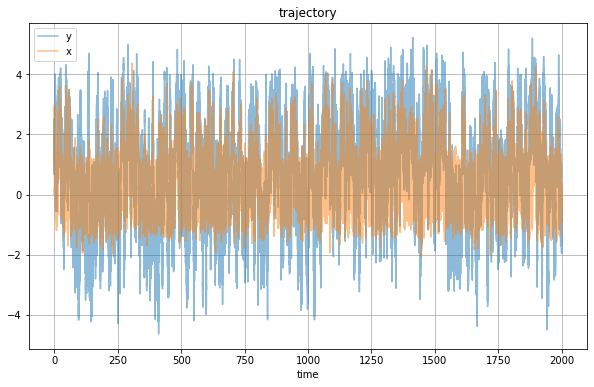

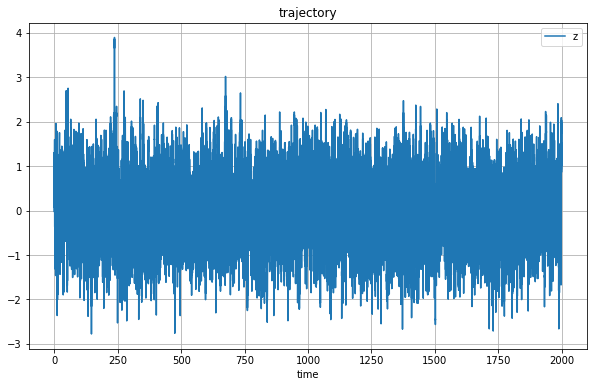

In [52]:
dt=0.001
Tmax=2000
q0=[0.2,0.7,1.3]
N=round(Tmax/dt)
D=1
kT=1

time=np.linspace(0,Tmax,N+1)
traj=run(D,dt,N,q0,kT)

plt.figure(figsize=(10,6))
plt.plot(time,traj[:,1],alpha=0.5,label='y')
plt.plot(time,traj[:,0],alpha=0.5,label='x')
#plt.plot(time,traj[:,2],label='z')
plt.title('trajectory')
plt.xlabel('time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(time,traj[:,2],label='z')
plt.title('trajectory')
plt.xlabel('time')
plt.legend()
plt.grid()

#### Histograms (estimated probabilities) and free energy

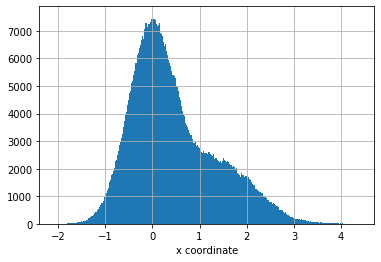

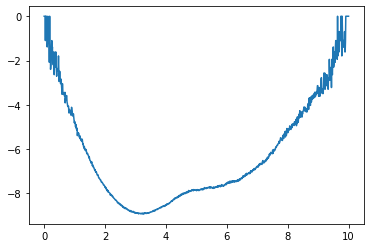

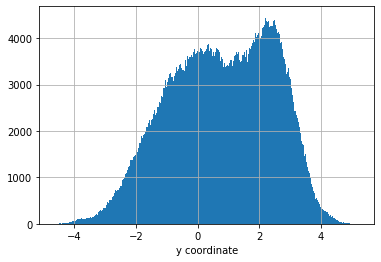

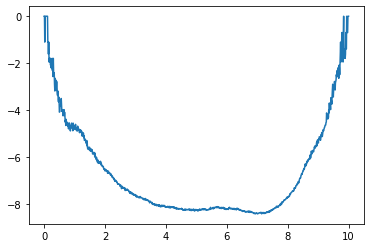

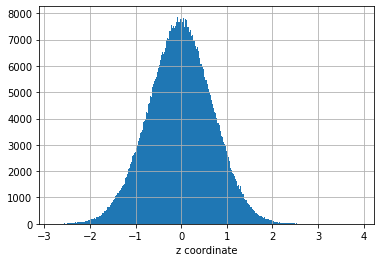

In [53]:
plt.figure()
nbins=1000
maxr=10
counts, bins, patches = plt.hist(traj[:,0], nbins)
plt.xlabel('x coordinate')
plt.grid(axis='both')
plt.show()
plt.figure()
Fexact=-np.log(counts, out=np.zeros_like(counts), where=(counts!=0))
plt.plot(np.linspace(0,maxr,nbins),Fexact,'-')#,'--')

plt.figure()
counts, bins, patches = plt.hist(traj[:,1], nbins)
plt.xlabel('y coordinate')
plt.grid(axis='both')
plt.show()
plt.figure()
Fexact=-np.log(counts, out=np.zeros_like(counts), where=(counts!=0))
plt.plot(np.linspace(0,maxr,nbins),Fexact,'-')#,'--')

plt.figure()
counts, bins, patches = plt.hist(traj[:,2], nbins)
plt.xlabel('z coordinate')
plt.grid(axis='both')
plt.show()


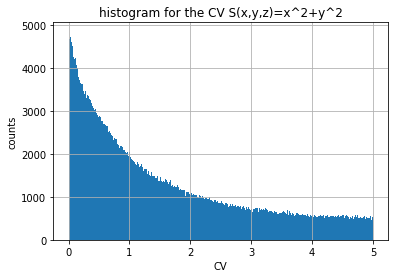

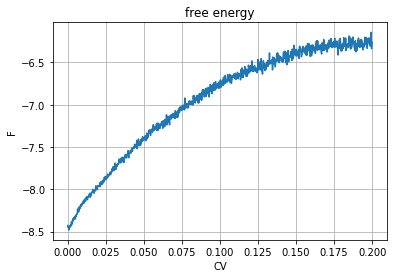

In [55]:
#a=np.sqrt(traj[:,0]**2+traj[:,1]**2)
a=traj[:,0]**2+traj[:,1]**2
maxr=10
counts, bins, patches = plt.hist(a, nbins,range=(0,5))#,range=(0,1))#,facecolor='green', alpha=0.5)
plt.xlabel('CV')
plt.ylabel('counts')
plt.title('histogram for the CV S(x,y,z)=x^2+y^2')
plt.grid(axis='both')
plt.show()

plt.figure()
Fexact=-np.log(counts, out=np.zeros_like(counts), where=(counts!=0))
#plt.plot(np.linspace(0,0.2,nbins),)
plt.plot(np.linspace(0,0.2,nbins),Fexact,'-')#,'--')
plt.title('free energy')
plt.xlabel('CV')
plt.ylabel('F')
plt.grid()


#### Plot of the potential energy as a f. of the (sqrt of the) CV r and the angle theta

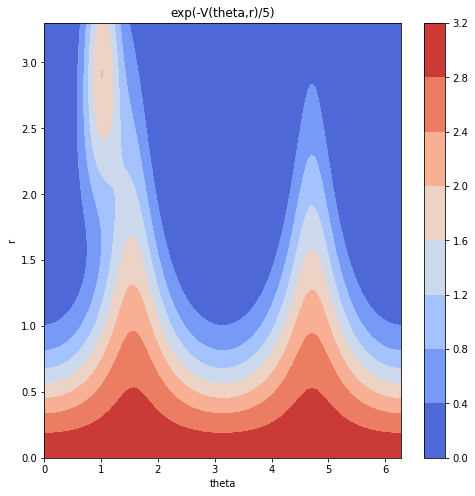

In [39]:
theta=np.linspace(0,2*np.pi,100)
r=np.linspace(0,3.3,100)
theta,r=np.meshgrid(theta,r)

cos=np.cos(theta)
sin=np.sin(theta)
exp1=np.exp(-2*r**2*cos**2-1/4*r**2*sin**2)
exp2=np.exp(-(r*cos-3/2)**2-(r*sin-5/2)**2)
V=-5*np.log(3*exp1+2*exp2)
p=(3*exp1+2*exp2)**5


#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)

plt.figure(figsize = (8,8))
#cs = plt.contourf(theta,r,V,cmap='coolwarm')
#plt.title('V(theta,r)')
#cs = plt.contourf(theta,r,p,cmap='coolwarm')
#plt.title('exp(-V(theta,r))')
cs = plt.contourf(theta,r,np.exp(-V/5),cmap='coolwarm')
plt.title('exp(-V(theta,r)/5)')

plt.colorbar(cs)
plt.xlabel('theta')
plt.ylabel('r')
plt.show()

### 2. Compute the free energy F(s) as a function of the collective variable s = x^2 + y^2 by thermodynamic integration.
### Estimate the error of the derivative of the free energy for each value of the CV, and estimate the error on the free energy difference F (10) − F (0) by error propagation.

In [40]:
def gradient2(r,theta,z):
    cos=np.cos(theta)
    sin=np.sin(theta)
    exp1=np.exp(-2*r**2*cos**2-1/4*r**2*sin**2)
    exp2=np.exp(-(r*cos-3/2)**2-(r*sin-5/2)**2)
    gradz=2*z#*5
    gradtheta=-(21/2*(r**2)*cos*sin*exp1+2*r*(-3*sin+5*cos)*exp2)/(3*exp1+2*exp2)#*5
    Q=1/(4*r**2)*(3*(8*(r*cos)**2+(r*sin)**2)*exp1+8*r*(cos*(r*cos-3/2)+sin*(r*sin-5/2))*exp2)/(3*exp1+2*exp2)#*5
    return [gradtheta,gradz,Q]

In [41]:
def run2(D,dt,N,r,thetaz=[0,0],kT=1): # [thetaz]=[theta,z]
    traj=[]
    Qs=[]
    grad=[0,0]
    traj.append(thetaz)
    
    for i in range(N):
        [grad[0],grad[1],Q]=gradient2(r,thetaz[0],thetaz[1])
        Qs.append(Q)
        rando=[np.random.normal(),np.random.normal()]
        thetaz[0]=thetaz[0]-(grad[0]/r)*D/kT*dt+np.sqrt(2*D*dt/r)*rando[0]
        thetaz[1]=thetaz[1]-grad[1]*D/kT*dt+np.sqrt(2*D*dt)*rando[1]
        thetaz=[thetaz[0],thetaz[1]]
        traj.append(thetaz)
    return np.array(traj),np.array(Qs)

#### Choice of the parameters

In [42]:
dt=0.01
Tmax=500
N=round(Tmax/dt)
D=1
kT=1

#### Example at fixed value of the collective variable r^2

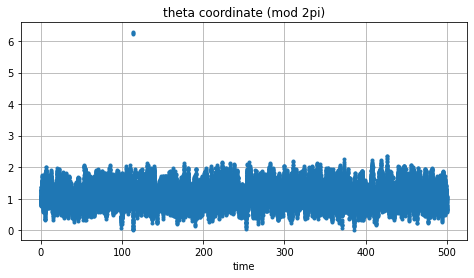

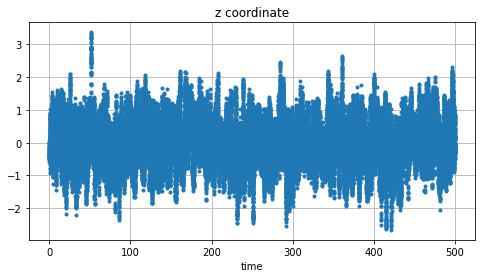

In [43]:
r=2.7 # 2.7 \sim sqrt(8)
thetaz=[1,0]

time=np.linspace(0,Tmax,N+1)
[traj,Qs]=run2(D,dt,N,r,thetaz,kT)

plt.figure(figsize=(8,4))
plt.plot(time,np.mod(traj[:,0],2*np.pi),'.')
plt.title('theta coordinate (mod 2pi)')
plt.xlabel('time')
plt.grid()

plt.figure(figsize=(8,4))
plt.plot(time,traj[:,1],'.')
plt.title('z coordinate')
plt.xlabel('time')
plt.grid()

angle of the center of the second gaussian: 1.0303768265243125


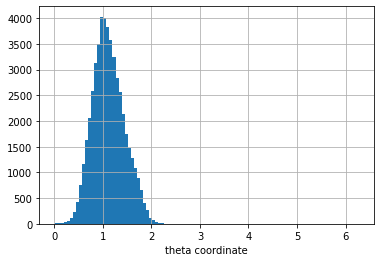

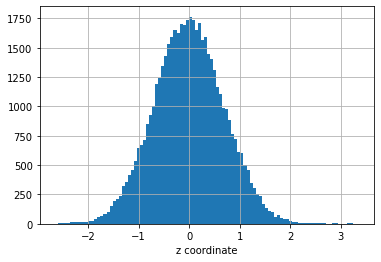

In [44]:
# histograms (estimated probability)
alfa=np.arctan(5/3)
print('angle of the center of the second gaussian:',alfa)

plt.figure()
#plt.subplot(0)
nbins=100
n, bins, patches = plt.hist(np.mod(traj[:,0],2*np.pi), nbins)#,facecolor='green', alpha=0.5)
plt.xlabel('theta coordinate')
plt.grid(axis='both')
plt.show()
alfa=np.arctan(5/3)
##print(np.mean(np.mod(traj[:,0],2*np.pi)))

plt.figure()
n, bins, patches = plt.hist(traj[:,1], nbins)#,facecolor='green', alpha=0.5)
plt.xlabel('z coordinate')
plt.grid(axis='both')
plt.show()

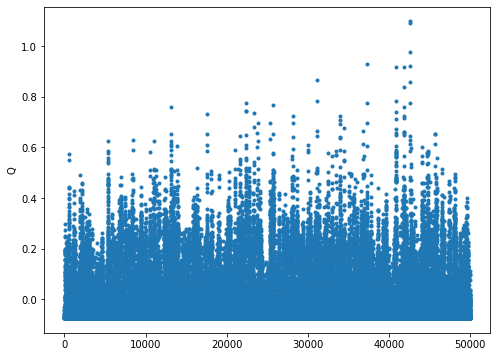

size= 50000
mean= 0.017331612152254
std (on the mean)= 0.0005274988418906803


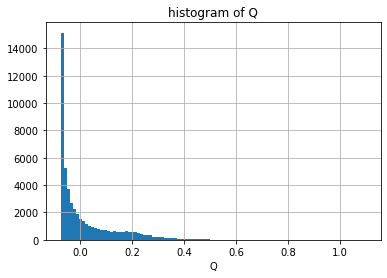

In [45]:
plt.figure(figsize=(8,6))
plt.plot(Qs,'.')
plt.ylabel('Q')
plt.show()
size=len(Qs)
print('size=',size)
mean=np.mean(Qs)
std=np.std(Qs)
print('mean=',mean)
print('std (on the mean)=',std/np.sqrt(len(Qs)))

plt.figure()
n, bins, patches = plt.hist(Qs, nbins)#,facecolor='green', alpha=0.5)
plt.title('histogram of Q')
plt.xlabel('Q')
plt.grid(axis='both')

#### block analysis

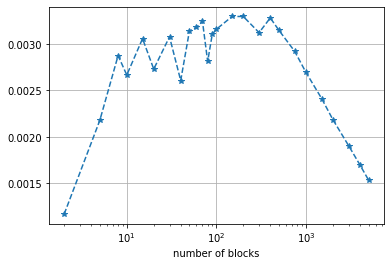

In [46]:
nbls=[2,5,8,10,15,20,30,40,50,60,70,80,90,100,150,200,300,400,500,750,1000,1500,2000,3000,4000,5000]#,7500,10000,20000]
#nbls=np.arange(2,500,3)
epsilon=np.zeros(len(nbls))
for j in range(len(nbls)):
    sizebl=int(size/nbls[j])
    #print(sizebl)
    a=0
    for i in range(nbls[j]):
        a+=(np.mean(Qs[(sizebl*i):(sizebl*(i+1))]))**2
    epsilon[j]=np.sqrt((a/nbls[j]-mean**2)/nbls[j])
    #epsilon[sizebl-1]=a    
plt.plot(nbls,epsilon,'*--')
plt.xlabel('number of blocks')
plt.xscale('log')
plt.grid()
#print(epsilon)

#### Set the value for the n. of blocks N_b

In [47]:
Nb=500
sizebl=int(size/Nb)

#### Thermodynamic integration

initial coordinates [theta,z] of the first run: [2.31868498547632, 0]
forward thermodynamic cycle


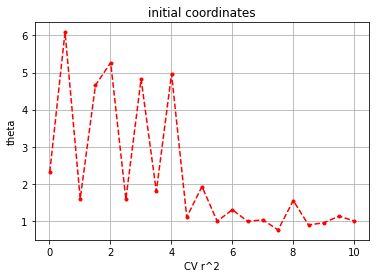

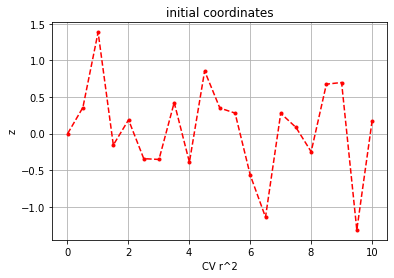

In [48]:
thetaz=[np.random.uniform(0,2*np.pi),0]
print('initial coordinates [theta,z] of the first run:',thetaz)

boole=1
if boole==1:
    print('forward thermodynamic cycle')
else:
    print('keep the same initial coordinates')
# if boole=1 then do "hysteresis" (thermodynamic) cycle, i.e. take as initial coordinate of the next run the same
# angle of the last position of the previous run; in this case, thetaz previously defined is the initial coordinate
# of the first run


delta=0.5
#rs2=np.arange(delta,10+delta,delta)
rs2=np.arange(0.01,10+delta,delta)
#rs2=np.concatenate(([0.01],rs2),axis=0)
#print('values of the CV r^2:',rs2)
#print(rs2)

Qavs=[]
Qerrs=[]
thetazs=np.zeros((len(rs2),2))


time=np.linspace(0,Tmax,N+1)
i=0
for r2 in rs2:
    #print(thetaz)
    thetazs[i,:]=thetaz
    i=i+1
    [traj,Qs]=run2(D,dt,N,np.sqrt(r2),thetaz,kT)
    if boole==1:
        thetaz=traj[N]
        thetaz=[np.mod(thetaz[0],2*np.pi),thetaz[1]]
    mean=np.mean(Qs)
    Qavs.append(mean)
    
    ## estimate of the error on the mean through block analysis for the previously specified number of blocks
        
    #print(sizebl)
    a=0
    for j in range(Nb):
        a+=(np.mean(Qs[(sizebl*j):(sizebl*(j+1))]))**2
    epsilon=np.sqrt((a/Nb-mean**2)/Nb)
    
    #Qstds.append(np.std(Qs))
    Qerrs.append(epsilon)

#Qstds=Qstds/np.sqrt(N)

if boole==1:
    plt.figure()
    plt.title('initial coordinates')
    plt.plot(rs2,thetazs[:,0],'.--r')
    plt.xlabel('CV r^2')
    plt.ylabel('theta')
    plt.grid()
    
    plt.figure()
    plt.title('initial coordinates')
    plt.plot(rs2,thetazs[:,1],'.--r')
    plt.xlabel('CV r^2')
    plt.ylabel('z')
    plt.grid()

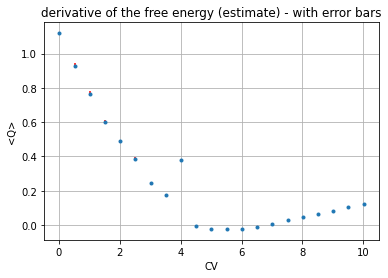

In [49]:
plt.plot(rs2,Qavs,'.')
Qerrs=np.array(Qerrs)
plt.errorbar(rs2,Qavs,Qerrs,linestyle='',color='r')
plt.title('derivative of the free energy (estimate) - with error bars')
plt.ylabel('<Q>')
plt.xlabel('CV')
plt.grid()

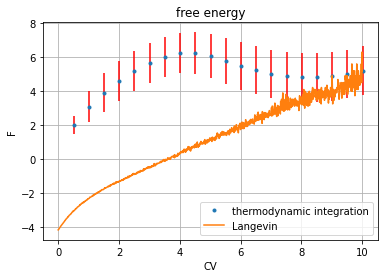

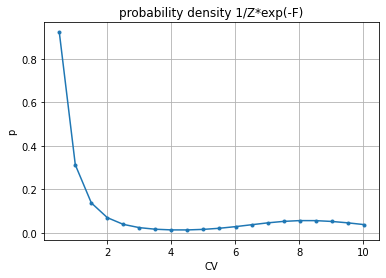

In [33]:
F=np.zeros(len(Qavs)-1)
for i in range(len(Qavs)-1):
    F[i]=Qavs[i]+Qavs[i+1]
F=np.cumsum(F)*delta/2 ## integral approx at first order

errF=np.zeros(len(F))
errF[0]=delta**2/4*(Qerrs[0]**2+Qerrs[1]**2)
for i in range(len(F)-1):
    errF[i+1]=errF[i]+delta**2/4*(3*Qerrs[i]**2+Qerrs[i+1]**2)
errF=np.sqrt(errF)


#F=np.cumsum(Qavs)*delta ## integral approx at order 0

plt.plot(rs2[1:],F,'.',label='thermodynamic integration')
#print(errF)
plt.errorbar(rs2[1:],F,errF,linestyle='',color='r')
Fexact=Fexact-(Fexact[-1]-F[-1])
#Fexact=Fexact-(Fexact[0]-F[0])
plt.plot(np.linspace(0,maxr,len(Fexact)),Fexact,'-',label='Langevin')#,'--')
plt.title('free energy')
plt.xlabel('CV')
plt.ylabel('F')
plt.legend()
plt.grid()

plt.figure()
plt.plot(rs2[1:],np.exp(-F)/np.sum(np.exp(-F)*delta),'.-')
plt.title('probability density 1/Z*exp(-F)')
plt.xlabel('CV')
plt.ylabel('p')
plt.grid()
#plt.ylim([0,0.5])
#plt.yscale('log')

### 3. Estimate the error on the same free energy difference by performing a thermodynamic cycle.

In [39]:
rs2back=np.flip(rs2)
rs2back=rs2back[1:]
#print(rs2back)

In [ ]:
thetazsBack=np.zeros((len(rs2back),2))
QavsBack=[]
QerrsBack=[]
i=0
for r2back in rs2back:
    thetazsBack[i,:]=thetaz
    i=i+1
    [traj,Qs]=run2(D,dt,N,np.sqrt(r2back),thetaz,kT)
    if boole==1:
        thetaz=traj[N]
        thetaz=[np.mod(thetaz[0],2*np.pi),thetaz[1]]
        
    mean=np.mean(Qs)
    QavsBack.append(mean)
    
    ## estimate of the error on the mean through block analysis for the previously specified number of blocks
        
    #print(sizebl)
    a=0
    for j in range(Nb):
        a+=(np.mean(Qs[(sizebl*j):(sizebl*(j+1))]))**2
    epsilon=np.sqrt((a/Nb-mean**2)/Nb)
    
    #Qstds.append(np.std(Qs))
    QerrsBack.append(epsilon)
    
# r2ss=np.concatenate((rs2,rs2back),axis=0)

if boole==1:
    plt.figure()
    plt.title('initial coordinates - backward trajectory')
    plt.plot(rs2back,thetazsBack[:,0],'.--r')
    plt.xlabel('CV r^2')
    plt.ylabel('theta')
    plt.grid()
    
    plt.figure()
    plt.title('initial coordinates - backward trajectory')
    plt.plot(rs2back,thetazsBack[:,1],'.--r')
    plt.xlabel('CV r^2')
    plt.ylabel('z')
    plt.grid()

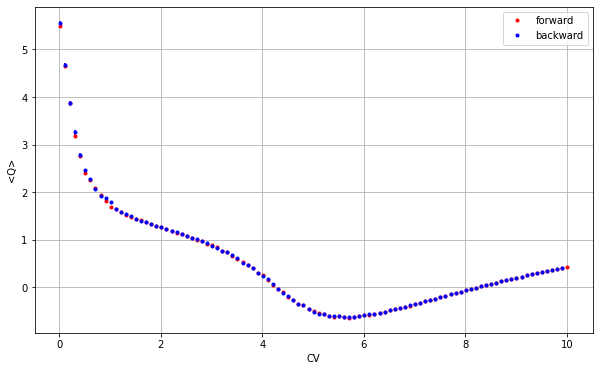

In [40]:
#plt.plot(r2ss,Qavs,'*')
plt.figure(figsize=(10,6))
plt.plot(rs2,Qavs,'.r',label='forward')
plt.errorbar(rs2,Qavs,Qerrs,linestyle='',color='r')
plt.plot(rs2back,QavsBack,'.b',label='backward')
QerrsBack=np.array(QerrsBack)
plt.errorbar(rs2back,QavsBack,QerrsBack,linestyle='',color='b')
##plt.title('theta initialized at 1 (trapped in the 1st min)')
plt.ylabel('<Q>')
plt.xlabel('CV')
plt.legend()
plt.grid()

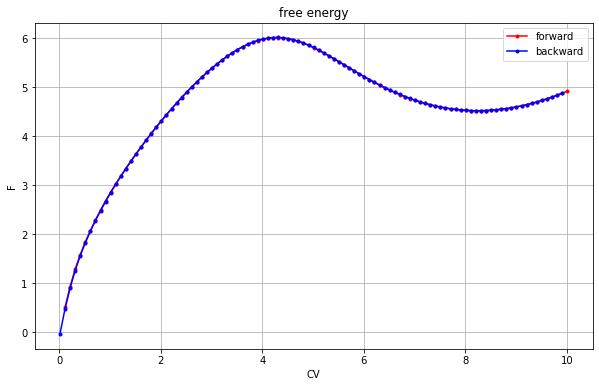

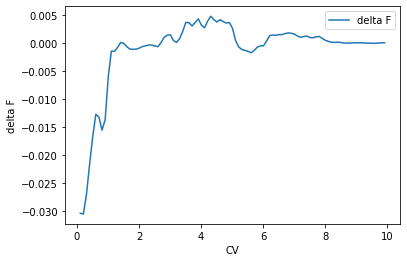

In [41]:
Fback=np.zeros(len(QavsBack))
Fback[0]=Qavs[len(Qavs)-1]+QavsBack[0]
for i in range(len(Fback)-1):
    Fback[i+1]=QavsBack[i+1]+QavsBack[i]
Fback=F[len(F)-1]-np.cumsum(Fback)*delta/2 ## integral approx at first order -- F[len(F)-1] is the last element of F

plt.figure(figsize=(10,6))
plt.plot(rs2[1:],F,'.-r',label='forward')
plt.plot(rs2back,Fback,'.-b',label='backward')
plt.grid()
plt.title('free energy')
plt.ylabel('F')
plt.xlabel('CV')
plt.legend()

plt.figure()
plt.plot(rs2[1:-1],-F[:-1]+np.flip(Fback)[1:],label='delta F')
#plt.plot(errF[:-1],label='error on F')
#plt.plot(np.flip(F[:-1])-Fback[1:])
#plt.plot(Fback)
plt.xlabel('CV')
plt.ylabel('delta F')
plt.legend()
plt.show()